In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns

import sklearn
import sklearn.model_selection as ms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.cluster import KMeans 
from sklearn.ensemble import GradientBoostingRegressor
# import xgboost

pd.set_option('display.max_columns', 999)

In [2]:
print(sklearn.__version__)   # version 22

0.21.2


#### Extract

In [3]:
train_house = pd.read_csv('train.csv', index_col = 0)

In [4]:
test_house = pd.read_csv('test.csv', index_col = 0)

In [5]:
# all_data = pd.concat([train_house.copy().drop(columns=['SalePrice']), test_house.copy()], axis=0)# concatenates on the datasets index
all_data = pd.concat([train_house.copy(), test_house.copy()], axis=0, sort=True)

- write csv for imputation in R, a new python package for imputation/missingness not covered

In [6]:
all_data.to_csv('alldata.csv', index=False,header=True) 

_Feature types split_

In [7]:
categorical_feat = train_house.columns[train_house.dtypes=='object']
categorical_features = categorical_feat.to_list()

In [8]:
numerical_feat = train_house.columns[(train_house.dtypes == 'int64') | (train_house.dtypes == 'float64')]
numerical_features = numerical_feat.to_list() 

## Experimental Data Analysis

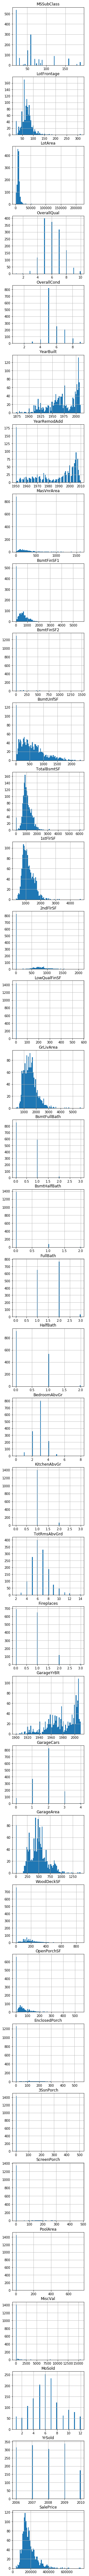

In [9]:
fig, axes = plt.subplots(37, 1, figsize=(4,37*4))               # just the distribution and not the errors 

for i, current_feat in enumerate(numerical_features):           # for numerical features
    train_house[current_feat].hist(bins=80, ax = axes[i]) 
    axes[i].title.set_text(current_feat)                        # titles 
    

In [10]:
def feat_list(feat_list):
    for i in range(0,len(feat_list)):
        print(train_house[lst_count[i]].value_counts())
        print('\n')
        

In [11]:
def feat_histograms(numerical_list):
    for i in range(0,len(numerical_list)):
        graph = 'graph_{}'.format(i)
        sns.distplot(train_house['SalePrice'], ax = graph)    

In [12]:
def feat_list(feat_list):
    for i in feat_list:
        print(train_house[i].value_counts())
        print('\n')

In [13]:
feat_list(categorical_features)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


Pave    1454
Grvl       6
Name: Street, dtype: int64


Grvl    50
Pave    41
Name: Alley, dtype: int64


Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neig

In [14]:
imputed_df = pd.read_csv('imputed_datafame_intergers.csv')

- another imputed dataframe, also imputed all_data dataframe through pandas

In [15]:
imputed_df.drop('Unnamed: 0', axis=1, inplace=True)   

In [16]:
def missingness(df):
    missing_features = df.columns[df.isna().any()]
    missing_train = df.isnull()
    missing_train = missing_train.sum()
    missing_train = missing_train[missing_train>0].sort_values(ascending=False)
    return missing_train[missing_train>0]

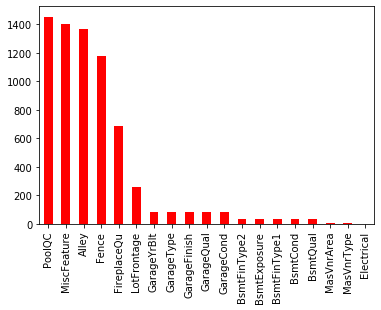

In [17]:
missingness(train_house)[:20].plot(kind='bar', color = 'r', sort_columns = False)  #Training data 

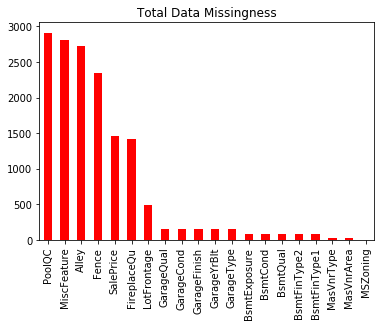

In [18]:
missing_plt = missingness(all_data)[:20].plot(kind='bar', color = 'r', sort_columns = False, title = 'Total Data Missingness')   #All data
plt.savefig()

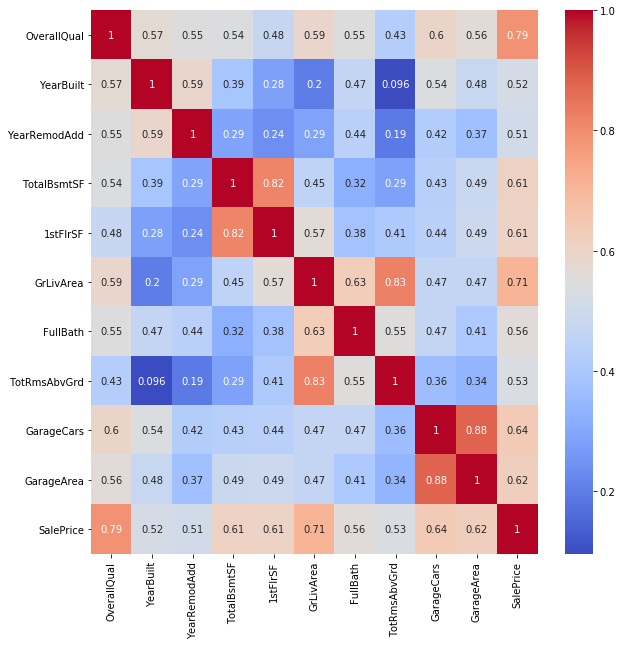

In [19]:
plt.rcParams['figure.figsize'] = [10.0, 10.0]
corr = train_house.corr()
sns.heatmap(train_house[corr[corr['SalePrice'].abs()>0.5].index].corr(),annot=True,cmap="coolwarm")
plt.savefig('correlationMatrix_wHeatmap.png',bbox_inches='tight')

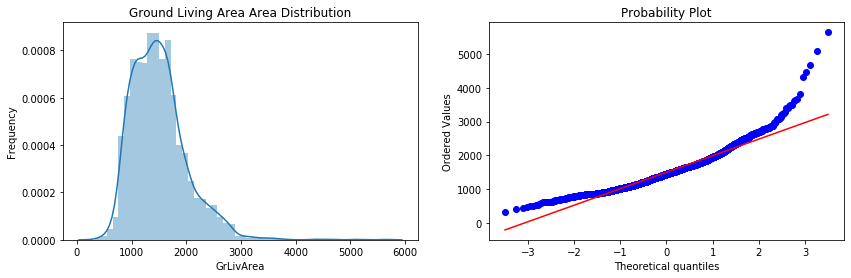

In [20]:
fig, (graph_1, graph_2) = plt.subplots(1, 2, figsize=(14, 4))

sns.distplot(all_data['GrLivArea'], ax = graph_1)
# graph_1.legend(['Normal dist. $\mu=$ {.2f}%'.format(mu)], loc = 'best')
# ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
graph_1.set_ylabel('Frequency')
graph_1.set_title('Ground Living Area Area Distribution')

graph_2 = plt.subplot(122)
res = stats.probplot(all_data['GrLivArea'], plot=plt)
plt.show()

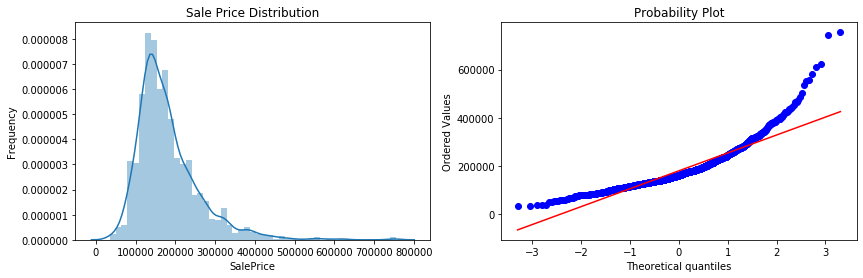

In [21]:
fig, (graph_1, graph_2) = plt.subplots(1, 2, figsize=(14, 4))

sns.distplot(train_house['SalePrice'], ax = graph_1)
# graph_1.legend(['Normal dist. $\mu=$ {.2f}%'.format(mu)], loc = 'best')
# ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
graph_1.set_ylabel('Frequency')
graph_1.set_title('Sale Price Distribution')

graph_2 = plt.subplot(122)
res = stats.probplot(train_house['SalePrice'], plot=plt)
plt.show()

_below is normalized is after Box-Cox method or log_

In [22]:
train_house_y = train_house['SalePrice']
y_log = np.log1p(train_house_y)

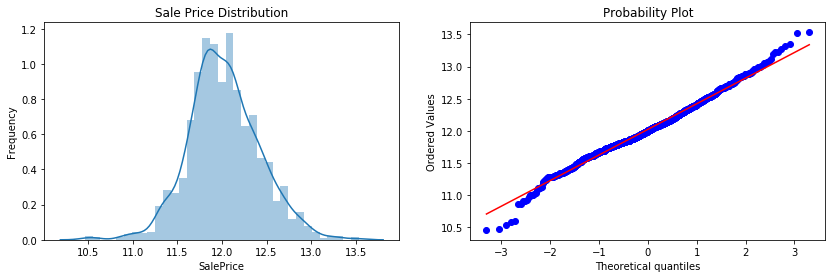

In [23]:
fig, (graph_1, graph_2) = plt.subplots(1, 2, figsize=(14, 4))

sns.distplot(y_log, ax = graph_1)
# graph_1.legend(['Normal dist. $\mu=$ {.2f}%'.format(mu)], loc = 'best')
# ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
graph_1.set_ylabel('Frequency')
graph_1.set_title('Sale Price Distribution')

graph_2 = plt.subplot(122)
res = stats.probplot(y_log, plot=plt)
plt.show()

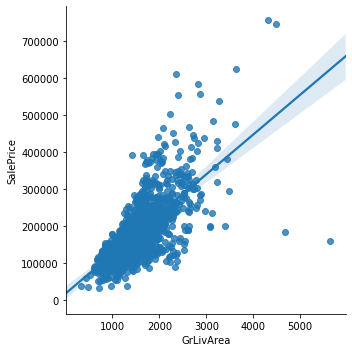

In [24]:
sns.lmplot(x='GrLivArea', y= 'SalePrice', data=train_house)

#### Transform
### Engineering features
_dependent or factors piped through imputation and removing variables_

#### preprocess

In [25]:
def process_missing(df):
   
    # fill LotFrontage missings with median value in the same neighborhood
    df['LotFrontage'] = df[['Neighborhood','LotFrontage']].groupby('Neighborhood').transform(lambda x: x.fillna(x.median()))

    # impute MSZoning missings as the most frequent value in the same MSSubClass
    df['MSZoning'] = df[['MSSubClass', 'MSZoning']].groupby('MSSubClass').transform(lambda x: x.fillna(x.mode()[0]))

    df['Utilities'] =df['Utilities'].fillna(df['Utilities'].mode()[0])

    df['Exterior1st'] = df['Exterior1st'].fillna('Wd Sdng')
    df['Exterior2nd'] = df['Exterior2nd'].fillna('Wd Sdng')

    df['Electrical']=df.groupby('Neighborhood')['Electrical'].transform(lambda x: x.fillna(x.mode()[0]))

    df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
    df['KitchenQual'] = df.groupby('Neighborhood')['KitchenQual'].transform(lambda x: x.mode()[0])
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    df[numerical_features] = df[numerical_features].fillna(0)
    df[categorical_feat] = df[categorical_feat].fillna('None')

    #print(df.head())
    return df

In [26]:
all_data = process_missing(all_data)

In [27]:
all_data.isna().any().sum()

0

- 1 missing is for SalesPrice
- filter for GrLivArea

#### Outliers

In [28]:
all_data = all_data[(all_data['GrLivArea'] >= 4500) != (all_data['GrLivArea'] <= 7000)]       # df[(df['col1'] >= 1) & (df['col1'] <=1 )]

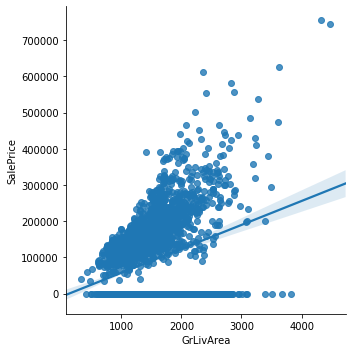

In [29]:
sns.lmplot(x='GrLivArea', y= 'SalePrice', data=all_data)

#### Collinarity

In [30]:
def Feat_engineering(data):
    df = data.copy()
    df['TotalBath'] = df['HalfBath']/2 + df['BsmtHalfBath']/2 + df['3SsnPrch'] + df['ScreenPorch'] + df['WoodDeckSF']
    
    new_columns = list(set(df.columns).difference(to_remove))
    return df[new_columns]

In [31]:
def Feat_engineering1(data):
    df = data.copy()
    # drop 'Id', 'Street', 'Utilities','PoolQC'
    to_remove=set(['Id', 'Street', 'Utilities','PoolQC', 'PoolArea', 'HalfBath', 'BsmtHalfBath', 'FullBath', 'BsmtFullBath',\
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF','TotalBsmtSF', '1stFlrSF',\
                  '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'YearBuilt', 'YearRemodAdd'])
    # convert PoolArea to binary
    df['HasPool'] = df['PoolArea'].apply(lambda x: 'Yes' if x>0 else 'No')

    # convert to categorical
    df[['KitchenAbvGr', 'TotRmsAbvGrd', 'BedroomAbvGr', 'GarageCars']] = df[['KitchenAbvGr', 'TotRmsAbvGrd', 'BedroomAbvGr', 'GarageCars']].astype(str)

    # combine features of 'HalfBath', 'BsmtHalfBath', 'FullBath', 'BsmtFullBath'
    df['TotalBath'] = df['HalfBath']/2 + df['BsmtHalfBath']/2 + df['FullBath'] + df['BsmtFullBath']
    df['TotalBath'] = df['TotalBath'].astype('str')

    # combine features of 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'WoodDeckSF'
    df['Total_PorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

    # combine features of TotalSF = TotalBsmtSF + X1stFlrSF + X2ndFlrSF
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    # combine features of 'BsmtFinSF1', 'BsmtFinSF2', 'X1stFlrSF', 'X2ndFlrSF'
    df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']

    # combine 'YearBuilt', 'YearRemodAdd'
    df['YearBuildRemod'] = df['YearBuilt'] + df['YearRemodAdd']

    # add new features
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 'Yes' if x>0 else 'No')

    df['Has2ndFlr'] = df['2ndFlrSF'].apply(lambda x: 'Yes' if x>0 else 'No')

    df['HasBasement'] = df['TotalBsmtSF'].apply(lambda x: 'Yes' if x>0 else 'No')

    new_columns = list(set(df.columns).difference(to_remove))
    

    return df[new_columns]

In [32]:
# all_data = Feat_engineering(all_data)

_zero missing features_

In [33]:
def df_extract_numeric_features(dataframe):
    # train_housing[(train_housing.dtypes == 'int64') | (train_housing.dtypes == 'float64')]
    train_housing = dataframe.copy()
    int_columns = train_housing.select_dtypes(['int64'])
    float_columns = train_housing.select_dtypes(['float64'])
    df_numeric = pd.concat([int_columns, float_columns], axis = 1, sort = False)
    return df_numeric

In [34]:
# df_numeric_train = df_extract_numeric_features(train_house)
df_numeric = df_extract_numeric_features(train_house)        # all data will be split again in train_test_split, there is another set from kaggle to test on
df_numeric = df_extract_numeric_features(all_data)                                                             # why split the data in the first place?

In [35]:
missingness(df_numeric)[:20]

Series([], dtype: int64)

In [36]:
df_numeric.describe()

1stFlrSF     2ndFlrSF    3SsnPorch  BedroomAbvGr  EnclosedPorch  \
count  2916.000000  2916.000000  2916.000000   2916.000000    2916.000000   
mean   1156.342250   335.976680     2.604938      2.860425      23.122085   
std     378.364282   428.147886    25.200989      0.822954      64.273020   
min     334.000000     0.000000     0.000000      0.000000       0.000000   
25%     876.000000     0.000000     0.000000      2.000000       0.000000   
50%    1082.000000     0.000000     0.000000      3.000000       0.000000   
75%    1384.000000   704.000000     0.000000      3.000000       0.000000   
max    3820.000000  2065.000000   508.000000      8.000000    1012.000000   

        Fireplaces     FullBath    GrLivArea     HalfBath  KitchenAbvGr  \
count  2916.000000  2916.000000  2916.000000  2916.000000   2916.000000   
mean      0.595679     1.567215  1497.018176     0.379630      1.044582   
std       0.644359     0.552501   492.507285     0.502737      0.214568   
min       0.000000     0.000000   334.000000     0.000000      0.000000   
25%       0.000000     1.000000  1125.750000     0.000000      1.000000   
50%       1.000000     2.000000  1443.000000     0.000000      1.000000   
75%       1.000000     2.000000  1743.000000     1.000000      1.000000   
max       4.000000     4.000000  4476.000000     2.000000      3.000000   

             LotArea  LowQualFinSF   MSSubClass       MiscVal       MoSold  \
count    2916.000000   2916.000000  2916.000000   2916.000000  2916.000000   
mean    10129.442387      4.699246    57.148491     45.048354     6.212277   
std      7789.680157     46.420449    42.533872    472.959838     2.712629   
min      1300.000000      0.000000    20.000000      0.000000     1.000000   
25%      7475.000000      0.000000    20.000000      0.000000     4.000000   
50%      9451.000000      0.000000    50.000000      0.000000     6.000000   
75%     11556.000000      0.000000    70.000000      0.000000     8.000000   
max    215245.000000   1064.000000   190.000000  15500.000000    12.000000   

       OpenPorchSF  OverallCond  OverallQual     PoolArea  ScreenPorch  \
count  2916.000000  2916.000000  2916.000000  2916.000000  2916.000000   
mean     47.130316     5.565158     6.085048     2.089506    16.078875   
std      66.641203     1.113556     1.405076    34.567277    56.210905   
min       0.000000     1.000000     1.000000     0.000000     0.000000   
25%       0.000000     5.000000     5.000000     0.000000     0.000000   
50%      26.000000     5.000000     6.000000     0.000000     0.000000   
75%      70.000000     6.000000     7.000000     0.000000     0.000000   
max     742.000000     9.000000    10.000000   800.000000   576.000000   

       TotRmsAbvGrd   WoodDeckSF    YearBuilt  YearRemodAdd       YrSold  \
count   2916.000000  2916.000000  2916.000000   2916.000000  2916.000000   
mean       6.445130    93.474280  1971.275377   1984.239712  2007.793210   
std        1.556508   126.276585    30.284550     20.890809     1.315471   
min        2.000000     0.000000  1872.000000   1950.000000  2006.000000   
25%        5.000000     0.000000  1953.000000   1965.000000  2007.000000   
50%        6.000000     0.000000  1973.000000   1993.000000  2008.000000   
75%        7.000000   168.000000  2001.000000   2004.000000  2009.000000   
max       14.000000  1424.000000  2010.000000   2010.000000  2010.000000   

        BsmtFinSF1   BsmtFinSF2  BsmtFullBath  BsmtHalfBath    BsmtUnfSF  \
count  2916.000000  2916.000000   2916.000000   2916.000000  2916.000000   
mean    437.640261    49.616255      0.428669      0.061043   560.323731   
std     439.303515   169.258662      0.523926      0.245113   439.666897   
min       0.000000     0.000000      0.000000      0.000000     0.000000   
25%       0.000000     0.000000      0.000000      0.000000   220.000000   
50%     368.000000     0.000000      0.000000      0.000000   467.000000   
75%     732.250000     0.000000      1.000000      0.

In [37]:
### 

In [38]:
def skew_values(data):
    data = df_numeric.copy()
    data = data.apply(lambda z: skew(z)).sort_values()
    return data

In [39]:
skew_high = skew_values(all_data)
skew_high[skew_high>.75]                  # Did not normalize skews, but should have model parameters set to normalize? parameter is different and you need box_cox to transform 

BsmtFinSF1        0.838067
2ndFlrSF          0.861039
BsmtUnfSF         0.920849
1stFlrSF          0.951859
GrLivArea         0.971914
SalePrice         1.099903
LotFrontage       1.102511
MSSubClass        1.374764
WoodDeckSF        1.844585
OpenPorchSF       2.495215
MasVnrArea        2.594532
BsmtHalfBath      3.943693
ScreenPorch       3.944305
EnclosedPorch     4.001570
BsmtFinSF2        4.143683
KitchenAbvGr      4.299698
3SsnPorch        11.370087
LowQualFinSF     12.082427
LotArea          13.187716
PoolArea         17.685603
MiscVal          22.179467
dtype: float64

In [40]:
skew_high = skew_high.index
# df_numeric = df_numeric[skew_high].apply(lambda x: boxcox1p(x, boxcox_normmax(x+1)))

In [41]:
all_data.shape

(2916, 80)

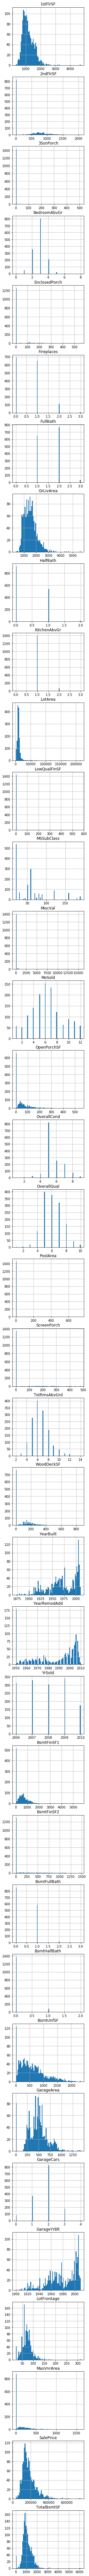

In [42]:
fig, axes = plt.subplots(df_numeric.shape[1], 1, figsize=(4,37*4))

for i, current_feat in enumerate(df_numeric):                # for numerical features
    train_house[current_feat].hist(bins=80, ax = axes[i]) 
    axes[i].title.set_text(current_feat)                     # titles 

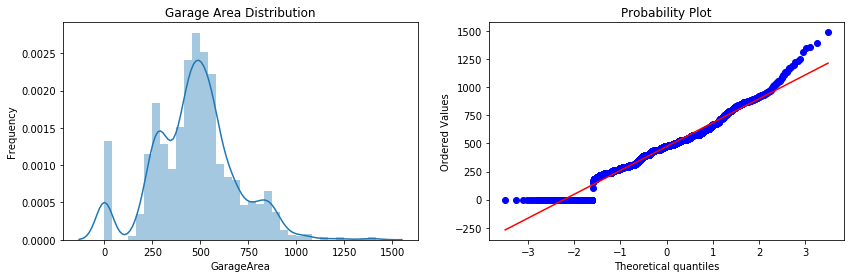

In [43]:
fig, (graph_1, graph_2) = plt.subplots(1, 2, figsize=(14, 4))

sns.distplot(train_house['GarageArea'], ax = graph_1)
# graph_1.legend(['Normal dist. $\mu=$ {.2f}%'.format(mu)], loc = 'best')
# ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
graph_1.set_ylabel('Frequency')
graph_1.set_title('Garage Area Distribution')

graph_2 = plt.subplot(122)
res = stats.probplot(all_data['GarageArea'], plot=plt)
plt.show()

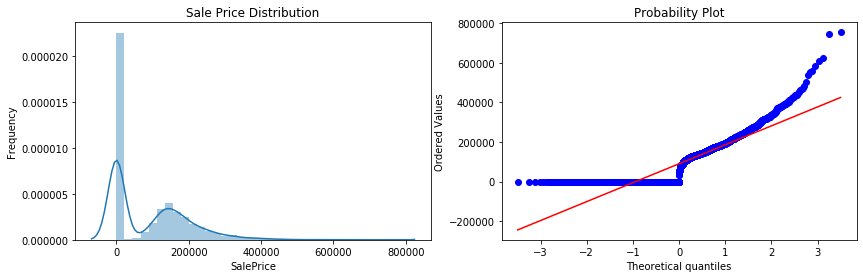

In [44]:
fig, (graph_1, graph_2) = plt.subplots(1, 2, figsize=(14, 4))

sns.distplot(all_data['SalePrice'], ax = graph_1)
# graph_1.legend(['Normal dist. $\mu=$ {.2f}%'.format(mu)], loc = 'best')
# ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
graph_1.set_ylabel('Frequency')
graph_1.set_title('Sale Price Distribution')

graph_2 = plt.subplot(122)
res = stats.probplot(all_data['SalePrice'], plot=plt)
plt.show()

_below is normalized is after Box-Cox method_

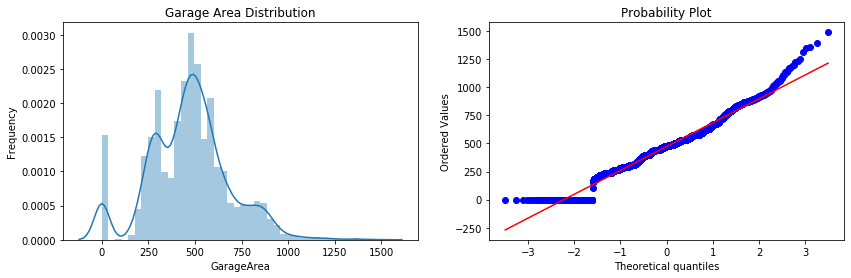

In [45]:
fig, (graph_1, graph_2) = plt.subplots(1, 2, figsize=(14, 4))

sns.distplot(df_numeric['GarageArea'], ax = graph_1)
# graph_1.legend(['Normal dist. $\mu=$ {.2f}%'.format(mu)], loc = 'best')
# ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
graph_1.set_ylabel('Frequency')
graph_1.set_title('Garage Area Distribution')

graph_2 = plt.subplot(122)
res = stats.probplot(all_data['GarageArea'], plot=plt)      # could change with quality feature since it most highly correlated to SalePrice
plt.show()

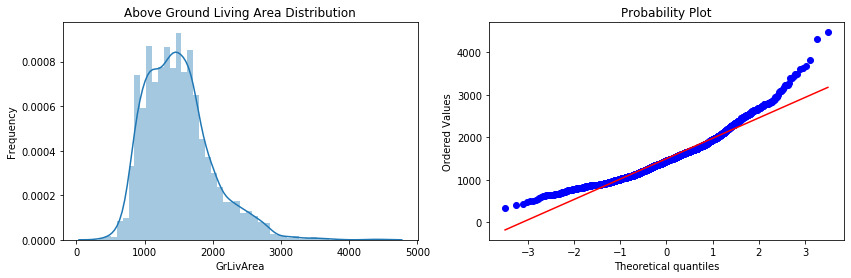

In [46]:
fig, (graph_1, graph_2) = plt.subplots(1, 2, figsize=(14, 4))

sns.distplot(df_numeric['GrLivArea'], ax = graph_1)
# graph_1.legend(['Normal dist. $\mu=$ {.2f}%'.format(mu)], loc = 'best')
# ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
graph_1.set_ylabel('Frequency')
graph_1.set_title('Above Ground Living Area Distribution')

graph_2 = plt.subplot(122)
res = stats.probplot(df_numeric['GrLivArea'], plot=plt)      # could change with quality feature since it most highly correlated to SalePrice
plt.show()

In [47]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
all_data.iloc[:1460]
saleprice = all_data['SalePrice'].iloc[:1460]         # df[(df['col1'] >= 1) & (df['col1'] <=1 )]   #1458

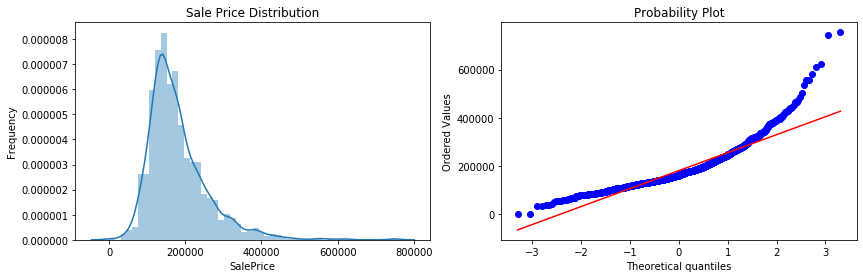

In [48]:
fig, (graph_1, graph_2) = plt.subplots(1, 2, figsize=(14, 4))

sns.distplot(saleprice, ax = graph_1)
# graph_1.legend(['Normal dist. $\mu=$ {.2f}%'.format(mu)], loc = 'best')
# ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
graph_1.set_ylabel('Frequency')
graph_1.set_title('Sale Price Distribution')

graph_2 = plt.subplot(122)
res = stats.probplot(saleprice, plot=plt)
plt.show()

In [49]:
# all_data.iloc[0:1460].shape       # shape is the same as train_house but all_data['SalePrice'] does not match 

In [50]:
train_house.shape       

(1460, 80)

In [51]:
train_house

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
6             50       RL         85.0    14115   Pave   NaN      IR1   
7             20       RL         75.0    10084   Pave   NaN      Reg   
8             60       RL          NaN    10382   Pave   NaN      IR1   
9             50       RM         51.0     6120   Pave   NaN      Reg   
10           190       RL         50.0     7420   Pave   NaN      Reg   
11            20       RL         70.0    11200   Pave   NaN      Reg   
12            60       RL         85.0    11924   Pave   NaN      IR1   
13            20       RL          NaN    12968   Pave   NaN      IR2   
14            20       RL         91.0    10652   Pave   NaN      IR1   
15            20       RL          NaN    10920   Pave   NaN      IR1   
16            45       RM         51.0     6120   Pave   NaN      Reg   
17            20       RL          NaN    11241   Pave   NaN      IR1   
18            90       RL         72.0    10791   Pave   NaN      Reg   
19            20       RL         66.0    13695   Pave   NaN      Reg   
20            20       RL         70.0     7560   Pave   NaN      Reg   
21            60       RL        101.0    14215   Pave   NaN      IR1   
22            45       RM         57.0     7449   Pave  Grvl      Reg   
23            20       RL         75.0     9742   Pave   NaN      Reg   
24           120       RM         44.0     4224   Pave   NaN      Reg   
25            20       RL          NaN     8246   Pave   NaN      IR1   
26            20       RL        110.0    14230   Pave   NaN      Reg   
27            20       RL         60.0     7200   Pave   NaN      Reg   
28            20       RL         98.0    11478   Pave   NaN      Reg   
29            20       RL         47.0    16321   Pave   NaN      IR1   
30            30       RM         60.0     6324   Pave   NaN      IR1   
31            70  C (all)         50.0     8500   Pave  Pave      Reg   
32            20       RL          NaN     8544   Pave   NaN      IR1   
33            20       RL         85.0    11049   Pave   NaN      Reg   
34            20       RL         70.0    10552   Pave   NaN      IR1   
35           120       RL         60.0     7313   Pave   NaN      Reg   
36            60       RL        108.0    13418   Pave   NaN      Reg   
37            20       RL        112.0    10859   Pave   NaN      Reg   
38            20       RL         74.0     8532   Pave   NaN      Reg   
39            20       RL         68.0     7922   Pave   NaN      Reg   
40            90       RL         65.0     6040   Pave   NaN      Reg   
41            20       RL         84.0     8658   Pave   NaN      Reg   
42            20       RL        115.0    16905   Pave   NaN      Reg   
43            85       RL          NaN     9180   Pave   NaN      IR1   
44            20       RL          NaN     9200   Pave   NaN      IR1   
45            20       RL         70.0     7945   Pave   NaN      Reg   
46           120       RL         61.0     7658   Pave   NaN      Reg   
47            50       RL         48.0    12822   Pave   NaN      IR1   
48            20       FV         84.0    11096   Pave   NaN      Reg   
49           190       RM         33.0     4456   Pave   NaN      Reg   
50            20       RL         66.0     7742   Pave   NaN      Reg   
51            60       RL          NaN    13869   Pave   NaN      IR2   
52            50       RM         52.0     6240   Pave   NaN      Reg   
53            90       RM        110.0     8472   Grvl   NaN    

In [52]:
train_house_y = saleprice
y_log = np.log1p(train_house_y)

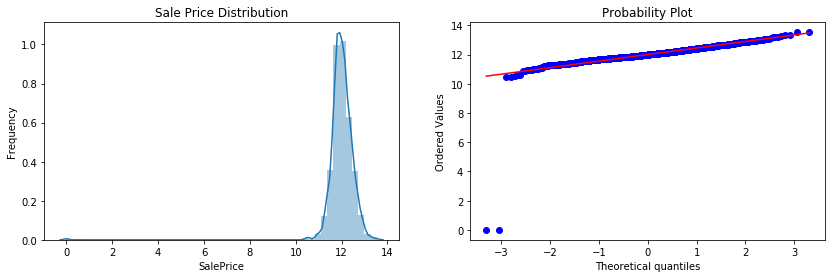

In [53]:
fig, (graph_1, graph_2) = plt.subplots(1, 2, figsize=(14, 4))

sns.distplot(y_log, ax = graph_1)
# graph_1.legend(['Normal dist. $\mu=$ {.2f}%'.format(mu)], loc = 'best')
# ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
graph_1.set_ylabel('Frequency')
graph_1.set_title('Sale Price Distribution')

graph_2 = plt.subplot(122)
res = stats.probplot(y_log, plot=plt)
plt.show()

In [54]:
all_data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [55]:
all_data = all_data.drop(columns = ['SalePrice'])

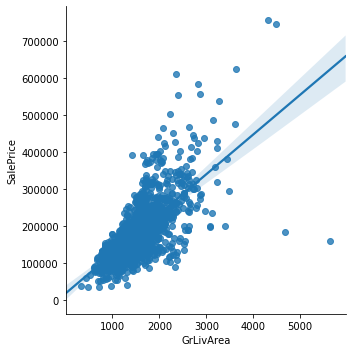

In [56]:
sns.lmplot(x='GrLivArea', y= 'SalePrice', data=train_house)

#### Load 
### Unsupervised Model 


In [57]:
from sklearn.cluster import KMeans 
from PlottingFunctions import plot_inertia, plot_silhouette 

In [58]:
kmeans_model = KMeans()   

In [59]:
kmeans_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

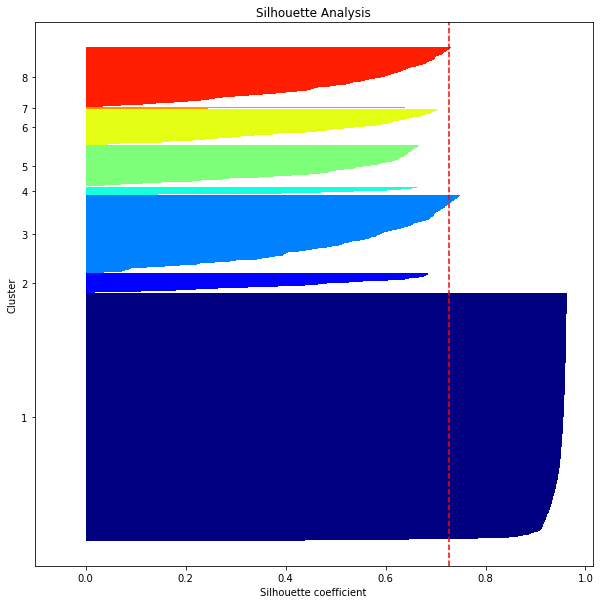

In [60]:
plot_silhouette(kmeans_model, df_numeric)               # make a new feature on 'all_data' from k-means model

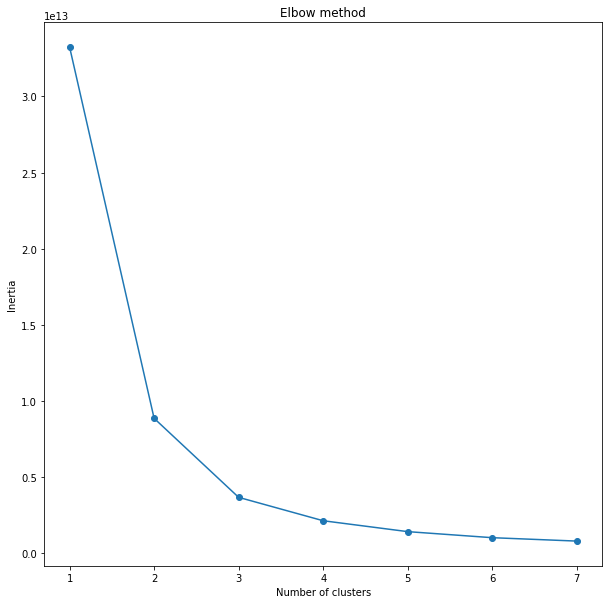

Wall time: 2.15 s


In [61]:
%time plot_inertia(kmeans_model, df_numeric, range(1,8))                     # Fits kmeans inside function call

In [62]:
# model_kmeans.cluster_centers_ # centriods for each cluster, may want to visualize as there are many or just create additonal feature 

In [63]:
kmeans_model.labels_

array([1, 1, 5, ..., 0, 0, 0])

In [64]:
# plt.scatter(imputed_df['GarageArea'],imputed_df['SalePrice'], c = model_kmeans.labels_, alpha=0.8)      # kmeans graph 
# plt.scatter(model_kmeans.cluster_centers_[:,0], model_kmeans.cluster_centers_[:,1], marker='+', s=1000, color = 'RGB')    

# plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_, alpha=0.8)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='+', s=1000, c=[0, 1])

In [65]:
numerical_feat = df_numeric.columns[(df_numeric.dtypes == 'int64') | (df_numeric.dtypes == 'float64')]
numerical_features = numerical_feat.to_list() 

In [66]:
# missingness(df_categorical)

In [67]:
# train model
train_house_X = train_house.iloc[:,0:79]

drop_numeric = df_numeric.dropna(axis=0, how='all')

# imputation 
drop_numeric.isna().sum()

# df_numeric['LotFrontage'].value_counts()
# df.dropna(axis=1, how='any')

1stFlrSF         0
2ndFlrSF         0
3SsnPorch        0
BedroomAbvGr     0
EnclosedPorch    0
Fireplaces       0
FullBath         0
GrLivArea        0
HalfBath         0
KitchenAbvGr     0
LotArea          0
LowQualFinSF     0
MSSubClass       0
MiscVal          0
MoSold           0
OpenPorchSF      0
OverallCond      0
OverallQual      0
PoolArea         0
ScreenPorch      0
TotRmsAbvGrd     0
WoodDeckSF       0
YearBuilt        0
YearRemodAdd     0
YrSold           0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtFullBath     0
BsmtHalfBath     0
BsmtUnfSF        0
GarageArea       0
GarageCars       0
GarageYrBlt      0
LotFrontage      0
MasVnrArea       0
SalePrice        0
TotalBsmtSF      0
dtype: int64

In [68]:
categorical_feats_engi = all_data.columns[all_data.dtypes=='object']
numerical_feats_engi = all_data.columns[all_data.dtypes!='object']

In [69]:
from sklearn.preprocessing import LabelEncoder
label_encode = LabelEncoder()
cat_labels_data = all_data.copy()
for i in categorical_feats_engi:
    cat_labels_data[i] = label_encode.fit_transform(cat_labels_data[i])

In [70]:
encoded_df = pd.concat([cat_labels_data, all_data[numerical_feats_engi]], axis=1)  

In [71]:
category_dummy = pd.get_dummies(all_data[categorical_feats_engi])           # categical transformed dummy data that adds features
data_dummy = pd.concat([category_dummy,all_data[numerical_feats_engi]], axis=1)  

In [72]:
print(all_data[categorical_feats_engi].shape)
print(category_dummy.shape)                          # PD.GET_DUMMIES added a lot of features 

(2916, 43)
(2916, 264)


In [73]:
# data_dummy.head(train_house.shape[0]).shape         # 309 features, higher features typically creates basis ridge.score(): 
                                                      #Train test R^2 score: 0.91602
                                                      #Test test R^2 score: 0.69857  

In [74]:
all_data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [75]:
X = data_dummy.head(train_house.shape[0])
X.shape

(1460, 300)

In [76]:
X_le = encoded_df.head(train_house.shape[0])
X_le.shape

(1460, 115)

In [77]:
train_house_y.shape

(1460,)

In [78]:
X_train, X_test, y_train, y_test = ms.train_test_split(X,train_house_y, test_size = .2, random_state = 132)  # 'X' parameter is the combined data 
                                                                                         # set random_state parameter 

In [79]:
skew_X = skew_values(X)
# print(skew_X)              # same skew numbers in X dataframe and original 
# print(skew_high)

In [80]:
train_idx = X_train.index
test_idx = y_train.index

In [81]:
train_x = X.loc[train_idx]
test_x = X.loc[test_idx]

### Ridge regularization 

In [82]:
ridge = Ridge() 

In [83]:
alphas = np.linspace(0,20,10)
coefs  = []
ridge_train_scores = []         # standard scalar prior to models 
ridge_test_scores = []
for alpha in alphas:
        ridge.set_params(alpha=alpha)
        ridge.fit(X_train, y_train)  
        coefs.append(ridge.coef_)
        ridge_train_scores.append(ridge.score(X_train, y_train))
        ridge_test_scores.append(ridge.score(X_test, y_test))
coefs = pd.DataFrame(coefs, index = alphas, columns = X_train.columns)  
coefs.head()

Alley_Grvl    Alley_None    Alley_Pave  BldgType_1Fam  \
0.000000 -6.822745e+14 -6.822745e+14 -6.822745e+14   2.851589e+14   
2.222222  2.019942e+03  5.673399e+02 -2.587282e+03   3.660321e+03   
4.444444  2.201970e+03  6.244035e+02 -2.826374e+03   3.692677e+03   
6.666667  2.191324e+03  6.600795e+02 -2.851403e+03   3.619000e+03   
8.888889  2.114161e+03  6.871597e+02 -2.801320e+03   3.518053e+03   

          BldgType_2fmCon  BldgType_Duplex  BldgType_Twnhs  BldgType_TwnhsE  \
0.000000     2.851589e+14     2.851589e+14    2.851589e+14     2.851589e+14   
2.222222     7.794839e+03    -8.925494e+02   -6.421639e+03    -4.140972e+03   
4.444444     5.961794e+03    -1.487630e+03   -5.054780e+03    -3.112061e+03   
6.666667     4.886385e+03    -1.850493e+03   -4.179118e+03    -2.475774e+03   
8.888889     4.154136e+03    -2.082831e+03   -3.562601e+03    -2.026757e+03   

           BsmtCond_Fa   BsmtCond_Gd  BsmtCond_None   BsmtCond_Po  \
0.000000 -2.666493e+14 -2.666493e+14  -1.414775e+13 -2.409531e+14   
2.222222 -2.579161e+03 -2.589458e+03   4.546050e+03  2.091013e+03   
4.444444 -2.242801e+03 -2.050350e+03   4.172109e+03  8.608647e+02   
6.666667 -2.171725e+03 -1.806358e+03   3.977264e+03  4.491220e+02   
8.888889 -2.155336e+03 -1.646742e+03   3.842999e+03  2.583625e+02   

           BsmtCond_TA  BsmtExposure_Av  BsmtExposure_Gd  BsmtExposure_Mn  \
0.000000 -2.666493e+14     4.731057e+14     4.731057e+14     4.731057e+14   
2.222222 -1.468443e+03    -1.597979e+03     1.242519e+04    -3.170912e+03   
4.444444 -7.398230e+02    -1.992148e+03     1.172482e+04    -3.438612e+03   
6.666667 -4.483029e+02    -2.129913e+03     1.132259e+04    -3.475241e+03   
8.888889 -2.992841e+02    -2.180059e+03     1.101939e+04    -3.442648e+03   

          BsmtExposure_No  BsmtExposure_None  BsmtFinType1_ALQ  \
0.000000     4.731057e+14       4.731057e+14      5.031660e+13   
2.222222    -6.512754e+03      -1.143546e+03     -1.981708e+03   
4.444444    -7.093643e+03       7.995794e+02     -1.749221e+03   
6.666667    -7.306476e+03       1.589038e+03     -1.649034e+03   
8.888889    -7.393410e+03       1.996732e+03     -1.599377e+03   

          BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  \
0.000000      5.031660e+13      5.031660e+13      5.031660e+13   
2.222222      7.809608e+02      2.747630e+03     -5.455650e+03   
4.444444      8.472558e+02      2.743248e+03     -5.138409e+03   
6.666667      8.837258e+02      2.719613e+03     -4.844325e+03   
8.888889      9.023671e+02      2.694129e+03     -4.582638e+03   

          BsmtFinType1_None  BsmtFinType1_Rec  BsmtFinType1_Unf  \
0.000000      -3.263149e+14      5.031660e+13      5.031660e+13   
2.222222       4.546050e+03     -4.239857e+03      3.602574e+03   
4.444444       4.172109e+03     -4.338137e+03      3.463154e+03   
6.666667       3.977264e+03     -4.398453e+03      3.311209e+03   
8.888889       3.842999e+03     -4.429090e+03      3.171610e+03   

          BsmtFinType2_ALQ  BsmtFinType2_BLQ  BsmtFinType2_GLQ  \
0.000000     -1.962032e+14     -1.962032e+14     -1.962032e+14   
2.222222      2.708051e+03     -5.724157e+03      4.957812e+03   
4.444444      2.579985e+03     -5.295448e+03      4.423723e+03   
6.666667      2.464015e+03     -4.921186e+03      3.859701e+03   
8.888889      2.356651e+03     -4.589137e+03      3.387244e+03   

          BsmtFinType2_LwQ  BsmtFinType2_None  BsmtFinType2_Rec  \
0.000000     -1.962032e+14       1.758728e+14     -1.962032e+14   
2.222222     -3.757442e+03       4.546050e+03     -2.679416e+03   
4.444444     -3.841707e+03       4.172109e+03     -1.994639e+03   
6.666667     -3.759505e+03       3.977264e+03     -1.571674e+03   
8.888889     -3.639768e+03       3.842999e+03     -1.292058e+03   

          BsmtFinType2_Unf   BsmtQual_Ex   BsmtQual_Fa   BsmtQual_Gd  \
0.000000     -1.962032e+14 -4.308631e+14 -4.308631e+14 -4.308631e+14   
2.222222     -5.089747e+01  9.995328e+03  9.851078e+01 -9.728032e+03   
4.444444     -4.402373e+01  1.0

Text(0.5, 1.0, 'Ridge coefficients for regularization')

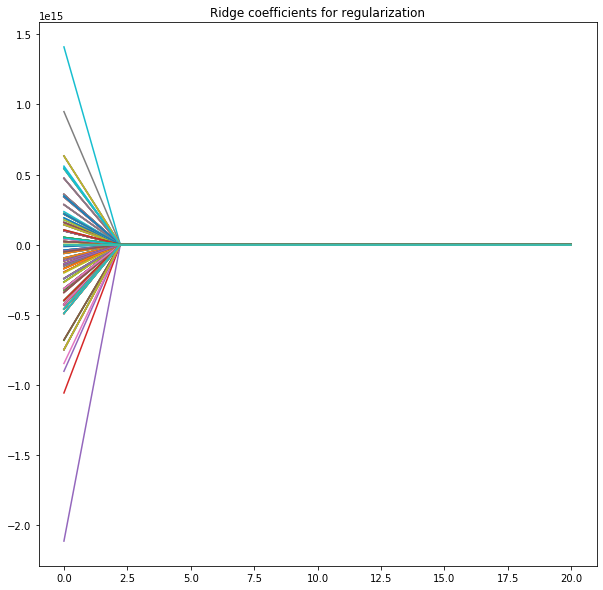

In [84]:
ax = plt.gca()
# plt.figure(figsize=[10,8])     # change size for graph size and alpha "steps"
ax.plot(alphas, coefs)

ax.set_xscale('linear')
plt.axis('tight')
plt.title('Ridge coefficients for regularization')

Text(0, 0.5, '$R^2$')

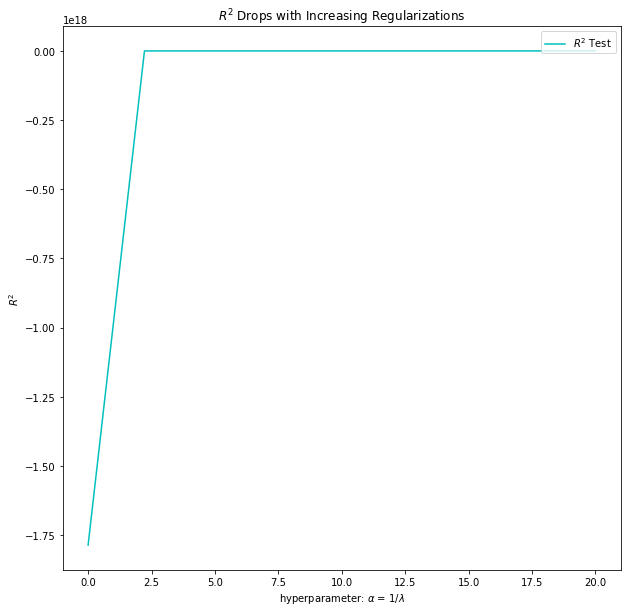

In [85]:
plt.plot(alphas, ridge_test_scores, c='c', label=r'$R^2$ Test')
plt.legend(loc=1)
plt.title(r'$R^2$ Drops with Increasing Regularizations')
plt.xlabel(r'hyperparameter: $\alpha$ = 1/$\lambda$')
plt.ylabel(r'$R^2$')

Text(0, 0.5, '$R^2$')

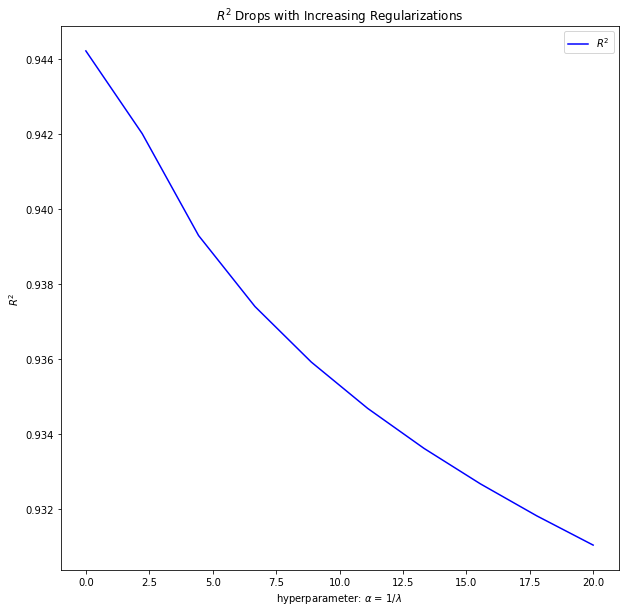

In [86]:
plt.plot(alphas, ridge_train_scores, c='b', label=r'$R^2$')
# plt.plot(alphas, ridge_test_scores, c='c', label=r'$R^2$ Test')
plt.legend(loc=1)
plt.title(r'$R^2$ Drops with Increasing Regularizations')
plt.xlabel(r'hyperparameter: $\alpha$ = 1/$\lambda$')
plt.ylabel(r'$R^2$')

In [87]:
alphas

array([ 0.        ,  2.22222222,  4.44444444,  6.66666667,  8.88888889,
       11.11111111, 13.33333333, 15.55555556, 17.77777778, 20.        ])

In [88]:
ridge.set_params(alpha=6.666666666666667, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=108, solver='auto', tol=0.001)                               # Normalizing cuts accuracy in half
ridge.fit(X_train, y_train)

Ridge(alpha=6.666666666666667, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=108, solver='auto', tol=0.001)

In [89]:
print('Train test R^2 score: %.5f' %ridge.score(X_train, y_train))
print('Test test R^2 score: %.5f' %ridge.score(X_test, y_test))

Train test R^2 score: 0.93740
Test test R^2 score: 0.87797


In [90]:
# alphas = 10**np.linspace(10,-2,100)
alphas = 100**np.linspace(10,-2,1000)*0.5   # why does this perform better? 
grid_para = {    "max_iter": [5, 10, 20],    
                     "alpha": alphas}      # '1 / lambda' = alpha  

grid_search_ridge = ms.GridSearchCV(ridge, cv=5, param_grid=grid_para, n_jobs=-1, verbose=0)  # lower alpha first then cv

In [91]:
%time grid_search_ridge.fit(X_train,y_train)  

Wall time: 3min 41s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=6.666666666666667, copy_X=True,
                             fit_intercept=True, max_iter=None, normalize=False,
                             random_state=108, solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([5.00000000e+19, 4.73092410e+19, 4.47632856e+19, 4.23543413e+19,
       4.00750348e+19, 3.79183896e+19, 3.58778046e+19, 3.39...
       1.43029777e-04, 1.35332604e-04, 1.28049655e-04, 1.21158640e-04,
       1.14638466e-04, 1.08469176e-04, 1.02631888e-04, 9.71087341e-05,
       9.18828100e-05, 8.69381200e-05, 8.22595294e-05, 7.78327180e-05,
       7.36441362e-05, 6.96809637e-05, 6.59310701e-05, 6.23829776e-05,
       5.90258264e-05, 5.58493409e-05, 5.28437986e-05, 5.00000000e-05]),
                         'max_iter': [5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [92]:
grid_search_ridge.best_params_  

{'alpha': 9.643957540103928, 'max_iter': 5}

In [93]:
grid_best = grid_search_ridge.best_estimator_.fit(X_train, y_train)
grid_best.score(X_train, y_train)       # same R^2 

0.9354709343340184

In [94]:
print(grid_search_ridge.score(X_train, y_train))    # scores are not as good as the single train-test-split, why?
print(grid_search_ridge.score(X_test, y_test)) 

0.9354709343340184
0.8796245670754115


In [95]:
y_train_grid = grid_search_ridge.predict(X_train)
y_test_grid = grid_search_ridge.predict(X_test)

Text(0.5, 1.0, 'Ridge cross validation - Grid Search')

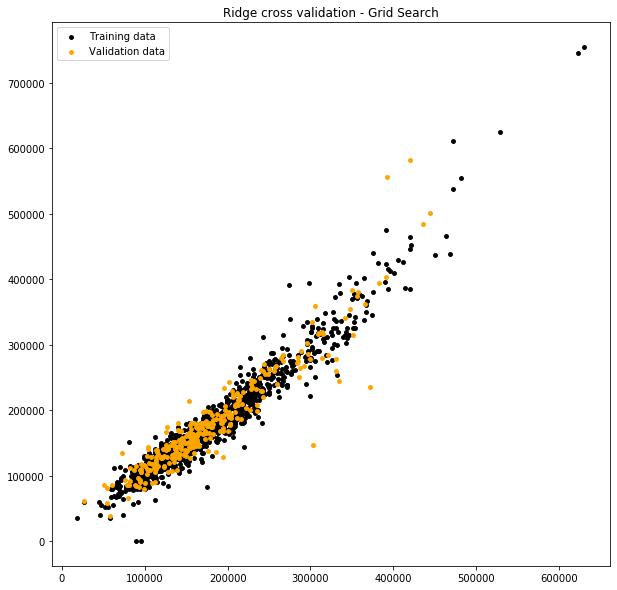

In [96]:
plt.scatter(y_train_grid, y_train, c='black', marker="o", s=15, label = "Training data")
plt.scatter(y_test_grid, y_test, c='orange', marker='o', s=15, label = "Validation data")
plt.legend(loc = "upper left")
plt.title('Ridge cross validation - Grid Search')

In [97]:
# print(X_test.shape, y_test_ridge.shape)

Text(0.5, 0, 'Actual')

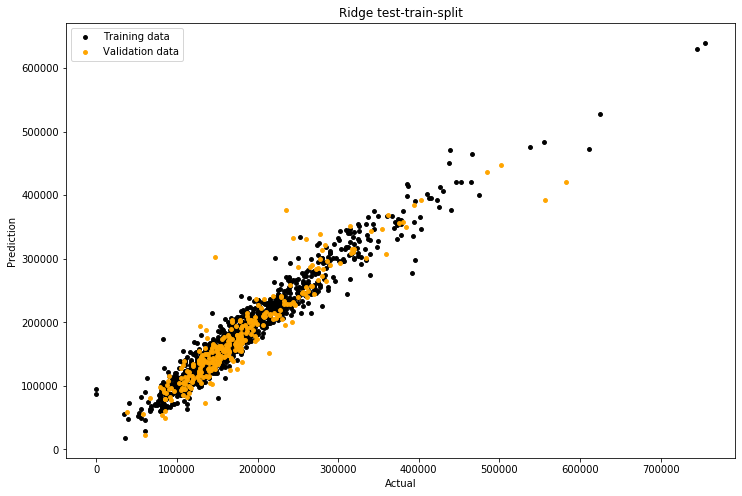

In [98]:
y_train_ridge = ridge.predict(X_train)
y_test_ridge = ridge.predict(X_test)
plt.figure(figsize=(12,8))
plt.scatter(y= y_train_ridge,x = y_train, c='black', marker="o", s=15, label = "Training data")
plt.scatter(y = y_test_ridge, x = y_test, c='orange', marker='o', s=15, label = "Validation data")
# plt.plot([0, 500000], [0, 500000], c = "grey")
plt.legend(loc = "upper left")
plt.title('Ridge test-train-split')
plt.ylabel('Prediction')
plt.xlabel('Actual')

# plt.xlim(0, 500000)
# plt.ylim(0, 500000)

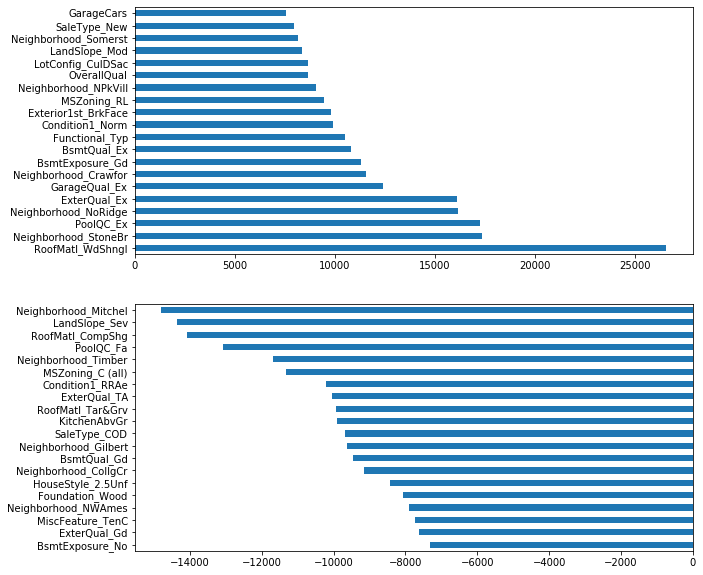

In [99]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10,10))
# fig, axes = plt.subplots(37, 1, figsize=(4,37*4))
top_coefs = pd.Series(ridge.coef_, index=X_train.columns).sort_values(ascending=False)[:20]
top_coefs2 = pd.Series(ridge.coef_, index=X_train.columns).sort_values(ascending=False)[-20:]           #.tail(20)
top_coefs.plot(kind='barh', ax=axes[0])
top_coefs2.plot(kind='barh', ax=axes[1])
plt.savefig('RidgeCoeffiencts.png',bbox_inches='tight')

In [100]:
# pd.Series(ridge.coef_,index=X_train.columns).sort_values(ascending=False)

#### Lasso regularzation 

In [101]:
lasso = Lasso()

In [102]:
lasso.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200772567099.47455, tolerance: 752694297.884891
  positive)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [103]:
print(lasso.score(X_train,y_train))   # train-test-split, 
print(lasso.score(X_test,y_test))

0.9469812965664565
0.8181765221415457


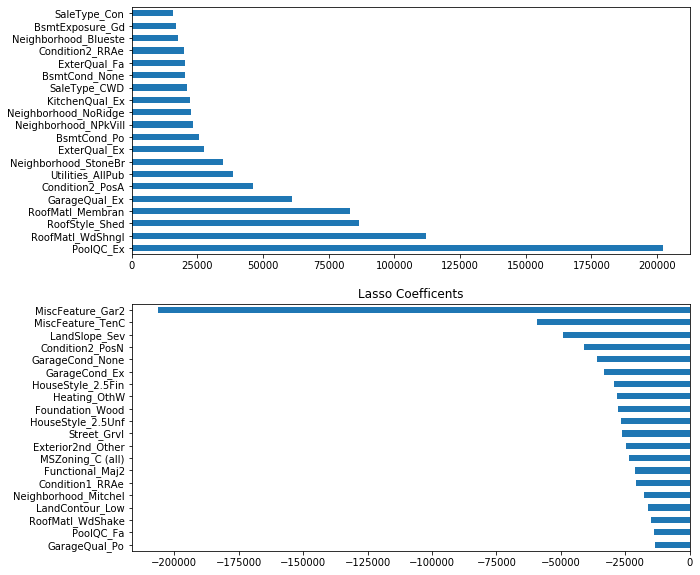

In [104]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10,10))
top_coefs_lasso = pd.Series(lasso.coef_, index=X_train.columns).sort_values(ascending=False)[:20]
top_coefs2_lasso = pd.Series(lasso.coef_, index=X_train.columns).sort_values(ascending=False)[-20:]           #.tail(20)
top_coefs_lasso.plot(kind='barh', ax=axes[0])
top_coefs2_lasso.plot(kind='barh', ax=axes[1])
plt.title('Lasso Coefficents')
plt.savefig('LassoCoefficents.png',bbox_inches='tight')

Text(0.5, 1.0, 'Lasso test-train-split')

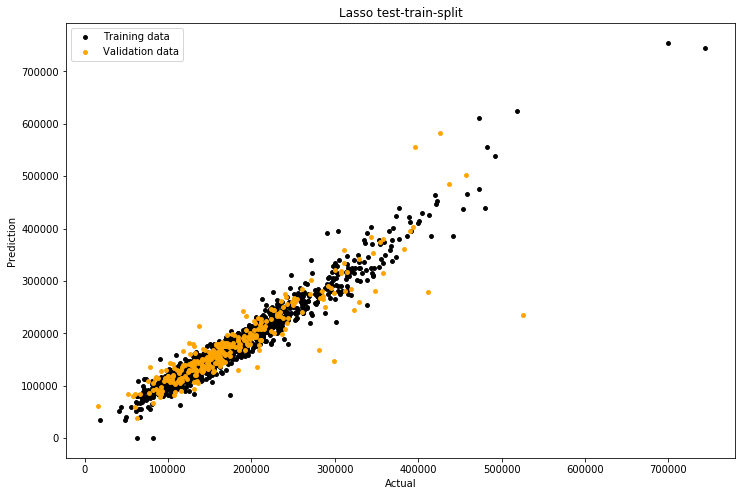

In [105]:
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
plt.figure(figsize=(12,8))
plt.scatter(y_train_lasso, y_train, c='black', marker="o", s=15, label = "Training data")
plt.scatter(y_test_lasso, y_test, c='orange', marker='o', s=15, label = "Validation data")
# plt.plot([0, 500000], [0, 500000], c = "grey")
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.legend(loc = "upper left")
plt.title('Lasso test-train-split')

In [106]:
alphas_lasso = np.linspace(0,250,251)
lasso.set_params(normalize=True)
lasso_coefs  = []
lasso_train_scores = []
lasso_test_scores = []
for alpha in alphas_lasso:
        lasso.set_params(alpha=alpha)
        lasso.fit(X_train, y_train)  
        lasso_coefs.append(lasso.coef_)
        lasso_train_scores.append(lasso.score(X_train, y_train))
        lasso_test_scores.append(lasso.score(X_test, y_test))
lasso_coeffs = pd.DataFrame(lasso_coefs, index = alphas_lasso, columns = X_train.columns)  
lasso_coeffs.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199449733549.55902, tolerance: 752694297.884891
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9397166681.184326, tolerance: 752694297.884891
  positive)


Alley_Grvl  Alley_None  Alley_Pave  BldgType_1Fam  BldgType_2fmCon  \
0.0  672.320301  771.736325 -930.703139    5971.318984     15215.413295   
1.0    0.000000    0.000000 -934.364704    3378.943169     10201.200993   
2.0   -0.000000    0.000000 -695.904468    3884.674052      8720.557281   
3.0   -0.000000    0.000000 -430.120155    4384.664182      7278.067714   
4.0   -0.000000   26.812949 -143.099399    4751.375010      6023.784911   

     BldgType_Duplex  BldgType_Twnhs  BldgType_TwnhsE  BsmtCond_Fa  \
0.0      3191.271823    -5360.228518     -3449.261017    91.600771   
1.0        -0.000000    -8202.174291     -5884.179381    84.119360   
2.0        -0.000000    -7350.947787     -5029.752624    -0.000000   
3.0        -0.000000    -6908.461508     -4599.478275    -0.000000   
4.0        -0.000000    -6383.129711     -4110.016766    -0.000000   

     BsmtCond_Gd  BsmtCond_None   BsmtCond_Po  BsmtCond_TA  BsmtExposure_Av  \
0.0 -1036.585534   24833.434479  38498.784861  -537.963796      3315.713958   
1.0  -338.747647   20342.819113  24477.252905    -0.000000      1837.511442   
2.0   -95.190876   17091.127745  17681.566215     0.000000      1553.654469   
3.0    -0.000000   15541.261543  11558.142176     0.000000      1165.573332   
4.0    -0.000000   14169.248108   5898.703570     0.000000       778.653150   

     BsmtExposure_Gd  BsmtExposure_Mn  BsmtExposure_No  BsmtExposure_None  \
0.0     18402.589375       1459.62712      -353.825383       -8055.093341   
1.0     17093.010347         -0.00000     -2030.348713          -0.000000   
2.0     17096.482309         -0.00000     -2355.635060           0.000000   
3.0     16987.429874         -0.00000     -2715.327377           0.000000   
4.0     16848.916076         -0.00000     -3097.950979           0.000000   

     BsmtFinType1_ALQ  BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  \
0.0      -4031.955491      -1354.980697        980.854001      -7847.519188   
1.0      -2758.906583         -0.000000       2035.436813      -6221.010769   
2.0      -2690.592032         -0.000000       1751.069572      -5960.002942   
3.0      -2670.482040         -0.000000       1473.732408      -5679.669576   
4.0      -2589.982430         -0.000000       1298.307097      -5292.552405   

     BsmtFinType1_None  BsmtFinType1_Rec  BsmtFinType1_Unf  BsmtFinType2_ALQ  \
0.0        8868.761308      -5779.279073       1540.664203       3884.236034   
1.0         352.566709      -4509.436749       2026.354366       4312.356583   
2.0         492.791170      -4570.518743       1221.286121       4922.646664   
3.0         382.096312      -4614.795445        518.527702       5595.152969   
4.0         125.921542      -4597.039264          0.000000       6308.192518   

     BsmtFinType2_BLQ  BsmtFinType2_GLQ  BsmtFinType2_LwQ  BsmtFinType2_None  \
0.0      -6536.732599       3784.545449      -3196.168141        -146.924603   
1.0      -6433.751906       3995.413047      -2708.545066         204.670609   
2.0      -5806.219442       4583.760738      -1990.011264          74.780468   
3.0      -5039.238109       5259.786426      -1270.492167           0.000000   
4.0      -4208.606849       6016.479013       -517.666857          16.579923   

     BsmtFinType2_Rec  BsmtFinType2_Unf   BsmtQual_Ex  BsmtQual_Fa  \
0.0      -3952.896299        154.730794  12905.164026  4771.875421   
1.0      -3169.615963          0.000000  12980.937093  3733.627710   
2.0      -2352.779538          0.000000  14015.568411  3414.564035   
3.0      -1564.549569          0.000000  14988.758534  2923.114853   
4.0       -714.997665          0.000000  15930.064274  2415.295781   

     BsmtQual_Gd  BsmtQual_None  BsmtQual_TA  CentralAir_N  CentralAir_Y  \
0.0 -4345.311760    -616.786491   807.373465    561.841600 -6.596360e-13   
1.0 -4470.763410    1008.030675    -0.000000    234.376444 -0.000000e+00   
2.0 -3821.563343    2436.559730    -0.000000      0.000000 -0.000000e+00   
3.0 -3261.438725    2872.179964  

Text(0.5, 1.0, 'Lasso coefficients for regularization')

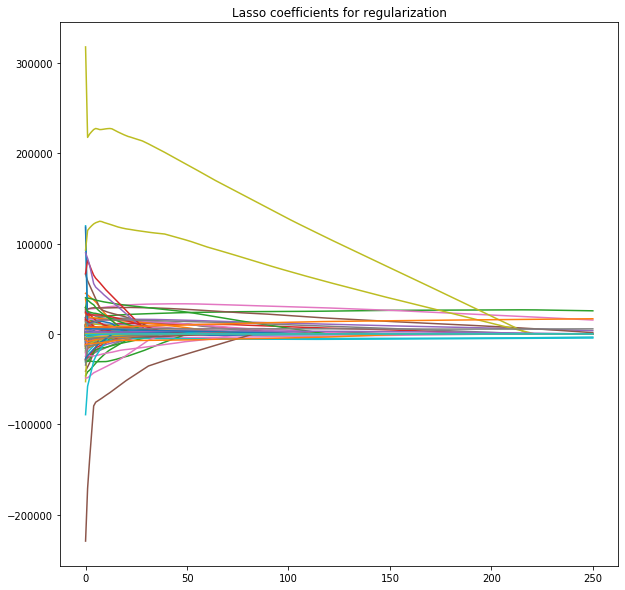

In [107]:
ax = plt.gca()
ax.plot(alphas_lasso, lasso_coefs)
ax.set_xscale('linear')
plt.axis('tight')
plt.title('Lasso coefficients for regularization')

Text(0.5, 1.0, 'Lasso coefficients for regularization aka Pick up sticks')

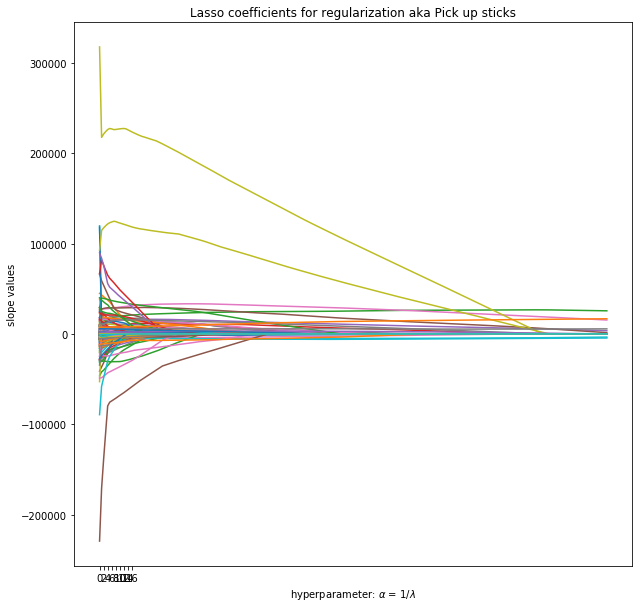

In [108]:
plt.rcParams['figure.figsize'] = (10,10)

for name in lasso_coeffs.columns:
    plt.plot(lasso_coeffs.index, lasso_coeffs[name], label=name)
# plt.legend(loc=6)   
plt.xticks(ticks=np.arange(0,18,step = 2))
plt.axis('tight')
# plt.yticks(ticks=np.arange(-9e18,9e18,step=1000))         # y-axis ticks are not forming to the plt graph (matplotlib)
# plt.set(xlim=(-0.5, 10.0), ylim=(-4,5))
plt.xlabel(r'hyperparameter: $\alpha$ = 1/$\lambda$')  
plt.ylabel(r'slope values')
plt.title('Lasso coefficients for regularization aka Pick up sticks')

In [109]:
# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

lasso_indexed_coefs = pd.Series(lasso.coef_, index = X_train.columns).sort_values(ascending=False) 
# print(lasso_indexed_coefs == -0.0000)          # for each lasso coefficent that coveraged 
# lasso_indexed_coefs.bool(-0.0000)   
# lasso_indexed_coefs

Text(0, 0.5, 'Accuracy with $R^2$')

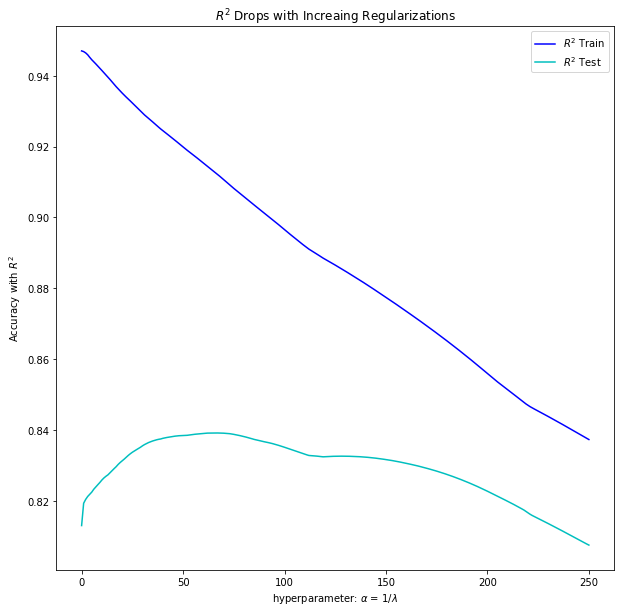

In [110]:
plt.plot(alphas_lasso, lasso_train_scores, c='b', label=r'$R^2$ Train')
plt.plot(alphas_lasso, lasso_test_scores, c='c', label=r'$R^2$ Test')
plt.legend(loc=1)
plt.title(r'$R^2$ Drops with Increaing Regularizations')
# plt.xlim(0,30)
# lasso_underfit = lasso_train_scores < lasso_test_scores        # erroring 
# last_underfit  = np.max(alphas_lasso[lasso_underfit])
# plt.axvline(last_underfit, linestyle='--', color='g', label='optimal lambda', alpha=0.4)
plt.xlabel(r'hyperparameter: $\alpha$ = 1/$\lambda$')
plt.ylabel(r'Accuracy with $R^2$')

In [111]:
dir(lasso)
lasso.max_iter

1000

In [112]:
# alphas = 10**np.linspace(1,-4,1)   
alphas = 100**np.linspace(10,-2,1000)*0.5
grid_para = {"max_iter": [10, 20, 30],           # not sure where the Lasso model coverages, graph display 
                     "alpha": alphas}

grid_search_lasso = ms.GridSearchCV(lasso, cv=5, param_grid=grid_para, n_jobs=-1, verbose=0)

In [113]:
%time grid_search_lasso = grid_search_lasso.fit(X_train, y_train)

Wall time: 2min 50s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66893816548.87793, tolerance: 752694297.884891
  positive)


In [114]:
grid_search_lasso.best_params_  

{'alpha': 22.111369902529574, 'max_iter': 30}

In [115]:
grid_search_lasso.best_estimator_.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66893816548.87793, tolerance: 752694297.884891
  positive)


Lasso(alpha=22.111369902529574, copy_X=True, fit_intercept=True, max_iter=30,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [116]:
print( grid_search_lasso.score(X_train, y_train))    # scores are not as good as the single train-test-split, why? what the alpha is set at .
print( grid_search_lasso.score(X_test, y_test)) 

0.93377058780353
0.8333256859450054


#### Elastic Net

In [117]:
elastic_net = ElasticNet()

In [118]:
elastic_net.set_params(normalize=False)  #l1_ratio is rho 

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [119]:
elastic_net.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481096516050.7545, tolerance: 752694297.884891
  positive)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [120]:
print('Elastic Net train: %.5f' %elastic_net.score(X_train, y_train))
print('Elastic Net test: %.5f' %elastic_net.score(X_test, y_test))

Elastic Net train: 0.89143
Elastic Net test: 0.84830


In [121]:
enet_alphas = np.linspace(-3,10,10)
# elastic_net.set_params(normalize=True)
enet_train_scores = [] 
enet_test_scores = []
enet_coefs = []
for alpha in enet_alphas: 
    elastic_net.set_params(alpha=alpha)
    elastic_net.fit(X_train, y_train)
    enet_coefs.append(elastic_net.coef_)
    enet_train_scores.append(elastic_net.score(X_train, y_train))
    enet_test_scores.append(elastic_net.score(X_test, y_test))
coefs = pd.DataFrame(enet_coefs, index=alphas, columns=X_train.columns)
coefs.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 752694297.884891
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 752694297.884891
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 752694297.884891
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 503002888958.40027, tolerance: 752694297.8848

ValueError: Shape of passed values is (10, 300), indices imply (1000, 300)

Text(0, 0.5, '$R^2$')

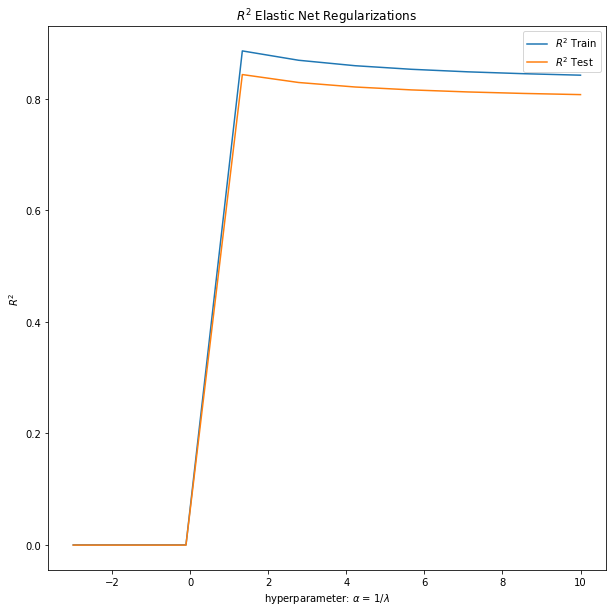

In [122]:
plt.plot(enet_alphas, enet_train_scores, label = r'$R^2$ Train')
plt.plot(enet_alphas, enet_test_scores, label = r'$R^2$ Test')
plt.legend(loc=1)
plt.title(r'$R^2$ Elastic Net Regularizations')
plt.xlabel(r'hyperparameter: $\alpha$ = 1/$\lambda$')
plt.ylabel(r'$R^2$')

### Tuning Hyperparameters

In [123]:
# param_grid_eNet = {"max_iter": [5, 10, 20],
#                     "alpha": 100**np.linspace(10,-2,1000),
#                     "l1_ratio": np.arange(0.0, 1.0, 0.1)}           # GridSearch defaults to a stratified k-fold for cross validation parameter 


grid_para = {"max_iter": [5, 10, 20],
            "alpha": 100**np.linspace(10,-2,1000)*0.5,
            "l1_ratio": np.arange(0.0, 1.0, 0.1)}

In [124]:
kf = KFold(n_splits = 5, shuffle = True)

In [125]:
grid_search_eNet = ms.GridSearchCV(elastic_net, grid_para, 
                                   cv= kf, n_jobs=-1, return_train_score = True)

In [126]:
%time grid_search_eNet.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361666790596.64417, tolerance: 752694297.884891
  positive)


Wall time: 32min 39s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=ElasticNet(alpha=10.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([5...
       1.14638466e-04, 1.08469176e-04, 1.02631888e-04, 9.71087341e-05,
       9.18828100e-05, 8.69381200e-05, 8.22595294e-05, 7.78327180e-05,
       7.36441362e-05, 6.96809637e-05, 6.59310701e-05, 6.23829776e-05,
       5.90258264e-05, 5.58493409e-05, 5.28437986e-05, 5.00000000e-05]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [5, 10, 20]},
      

In [127]:
grid_search_eNet.best_params_

{'alpha': 0.06638854146777132, 'l1_ratio': 0.0, 'max_iter': 20}

In [128]:
grid_eNet_ = grid_search_eNet.best_estimator_
grid_eNet_

ElasticNet(alpha=0.06638854146777132, copy_X=True, fit_intercept=True,
           l1_ratio=0.0, max_iter=20, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [129]:
grid_eNet_.score(X_train, y_train)
grid_eNet_.score(X_test,y_test)

0.8697052319783759

In [130]:
grid_enet = grid_search_eNet.best_estimator_

In [131]:
print('Train R^2 for Elastic Net model %.5f:' % grid_enet.score(X_train,y_train))
print('Test R^2 for Elastic Net model %.5f:' % grid_enet.score(X_test,y_test))

Train R^2 for Elastic Net model 0.91809:
Test R^2 for Elastic Net model 0.86971:


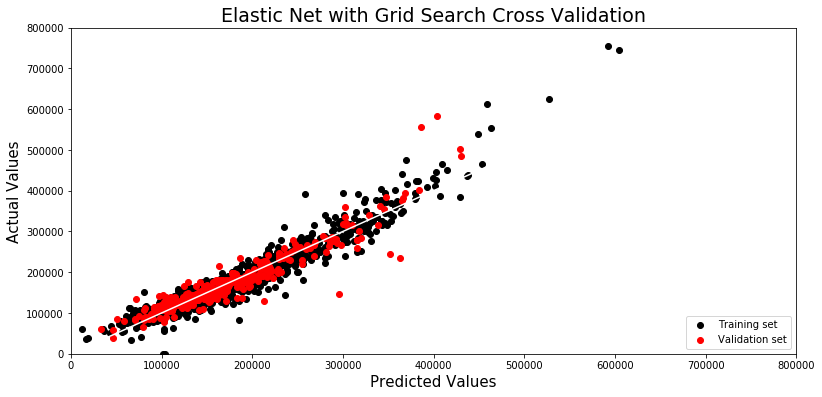

In [132]:
y_train_pred = grid_enet.predict(X_train)
y_test_pred = grid_enet.predict(X_test)

plt.figure(figsize=(13,6))
plt.scatter(y_train_pred, y_train,  c = 'black', label = 'Training set')
plt.scatter(y_test_pred, y_test, c = 'red', label = 'Validation set')
plt.title('Elastic Net with Grid Search Cross Validation', fontsize= 19)
plt.xlabel('Predicted Values', fontsize = 15)
plt.ylabel('Actual Values', fontsize = 15)

plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.plot([0, 800000], [0, 800000], c = "white")

plt.legend(loc = "lower right")


#### Random Forest Regression 

In [133]:
rf_regress = RandomForestRegressor()

In [134]:
rf_regress.set_params(bootstrap=False, criterion='mse', max_depth=19,
                      max_features=23, max_leaf_nodes=None,
                      min_impurity_decrease=1e-06, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0001, n_estimators=58,
                      n_jobs=None, oob_score=False, random_state=108, verbose=0,
                      warm_start=False)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=19,
                      max_features=23, max_leaf_nodes=None,
                      min_impurity_decrease=1e-06, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0001, n_estimators=58,
                      n_jobs=None, oob_score=False, random_state=108, verbose=0,
                      warm_start=False)

In [135]:
rf_regress.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=19,
                      max_features=23, max_leaf_nodes=None,
                      min_impurity_decrease=1e-06, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0001, n_estimators=58,
                      n_jobs=None, oob_score=False, random_state=108, verbose=0,
                      warm_start=False)

In [136]:
print('Train R^2 %.5f' % rf_regress.score(X_train,y_train))
print('Test R^2 %.5f' % rf_regress.score(X_test,y_test))
print('Test R^2 (different method) %.5f' %r2_score(y_test, rf_regress.predict(X_test)))

Train R^2 0.97222
Test R^2 0.84722
Test R^2 (different method) 0.84722


In [137]:
mean_squared_error(y_test, rf_regress.predict(X_test))  # why is this so high?

913255878.4132138

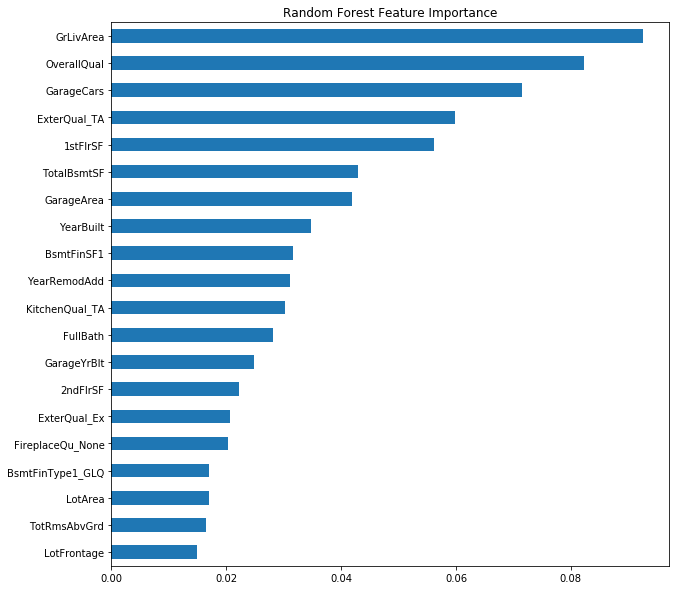

In [138]:
importance_feat_dia = pd.Series(rf_regress.feature_importances_, index = X_train.columns).sort_values(ascending=True)
importance_feat_dia.tail(20).plot(kind='barh', x=0,y=1)
plt.title('Random Forest Feature Importance')
plt.savefig('rf_features.png')
# plt.savefig('rf_features.png',bbox_inches='tight')

In [139]:
param_grid ={'max_depth': [20, 25, 30],
             'n_estimators': [500, 750, 1000, 1250, 1500]}

In [140]:
grid_search_rforest = ms.GridSearchCV(rf_regress, param_grid, scoring='neg_mean_squared_error', 
                                     cv= kf, n_jobs=-1, return_train_score = True)

In [141]:
%time grid_search_rforest.fit(X_train, y_train)         # too many features 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 3min 27s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=False, criterion='mse',
                                             max_depth=19, max_features=23,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=1e-06,
                                             min_impurity_split=None,
                                             min_samples_leaf=3,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0001,
                                             n_estimators=58, n_jobs=None,
                                             oob_score=False, random_state=108,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [20, 25,

In [142]:
grid_search_regressforest = grid_search_rforest.best_estimator_

In [143]:
print(grid_search_regressforest.score(X_train, y_train))
print(grid_search_regressforest.score(X_test, y_test))

0.9733620137485219
0.8540307547726752


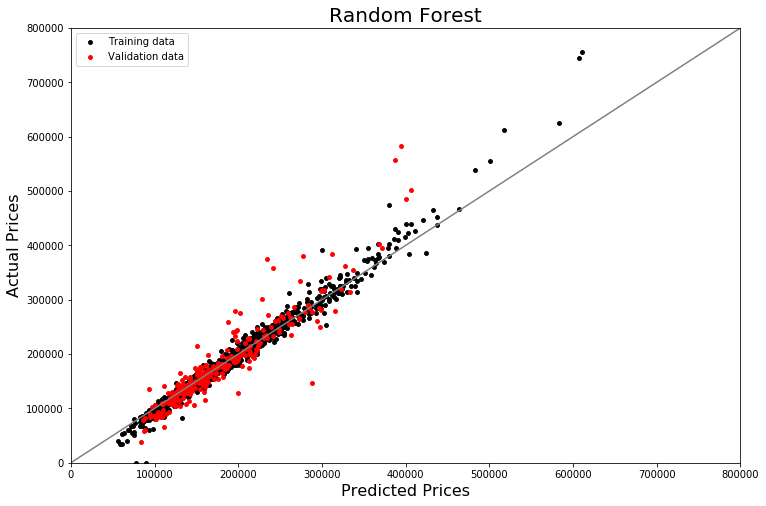

In [144]:
# scatter plot for training set and validation 
y_train_rForest = grid_search_rforest.predict(X_train)
y_test_rForest = grid_search_rforest.predict(X_test)

# Plot predictions
plt.figure(figsize=(12,8))
plt.scatter(y_train_rForest, y_train, c='black', marker="o", s=15, label = "Training data")
plt.scatter(y_test_rForest, y_test, c='red', marker='o', s=15, label = "Validation data")
plt.title("Random Forest", fontsize = 20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.show()

In [206]:
dt = pd.DataFrame(data=y_test_rForest, columns=['SalePrice'])
dt.to_csv('rf_submission.csv', header = True)

#### Gradient Boosting 

In [145]:
gbmr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='ls', max_depth=3,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2800,
                          n_iter_no_change=None, presort='auto',
                          random_state=108, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
# print(gbmr)
gbmr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='ls', max_depth=3,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2800,
                          n_iter_no_change=None, presort='auto',
                          random_state=108, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [146]:
param_grid = {'n_estimators': range(3000,5000,100),
               'max_features': [2],#range(2,4),
                }
grid_search_gbmr = ms.GridSearchCV(gbmr, param_grid=param_grid, cv=5, #scoring='neg_mean_squared_error', \
                                  return_train_score=True,n_jobs=-1, )

In [147]:
%time grid_search_gbmr.fit(X_train,y_train)

Wall time: 2min 15s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.03,
                                                 loss='ls', max_depth=3,
                                                 max_features=2,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=2,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=2800,
                                                 n_iter_no_change=None,
                 

In [148]:
print('Train R^2: %f' %grid_search_gbmr.score(X_train,y_train))
print('Test R_2: %f' %grid_search_gbmr.score(X_test,y_test))

Train R^2: 0.984209
Test R_2: 0.896893


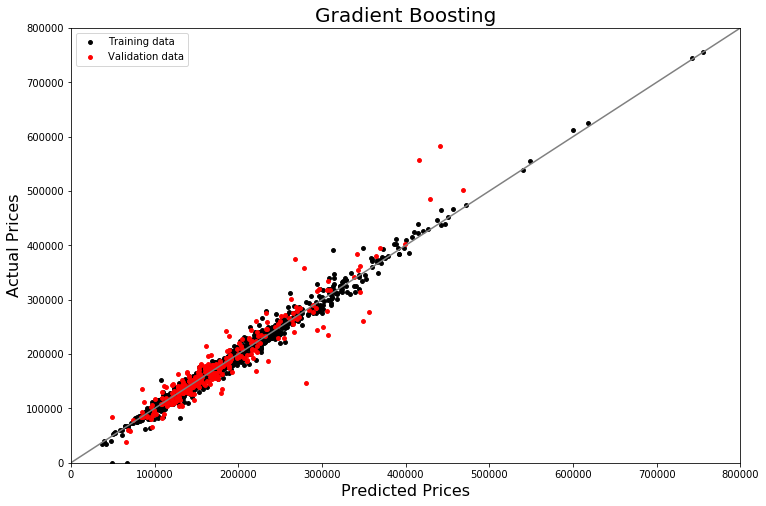

In [149]:
y_train_gbmr = grid_search_gbmr.predict(X_train)
y_test_gbmr = grid_search_gbmr.predict(X_test)

# Plot predictions
plt.figure(figsize=(12,8))
plt.scatter(y_train_gbmr, y_train, c='black', marker="o", s=15, label = "Training data")
plt.scatter(y_test_gbmr, y_test, c='red', marker='o', s=15, label = "Validation data")
plt.title("Gradient Boosting", fontsize = 20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.show()

In [188]:
type(y_test_gbmr)

numpy.ndarray

In [207]:
dt = pd.DataFrame(data=y_test_gbmr, columns=['SalePrice'])
dt.to_csv('gbm_submission.csv', header = True)

In [ ]:
# xgb = xgb()

In [ ]:
# gbm_params = {'n_estimators': range(500,1500,100),# 
#           'max_depth': [3], #range(3,10),
#           'learning_rate': np.linspace(0.01,0.2,11),
#          }

# grid_search_xgb = ms.GridSearchCV(xgb, gbm_params, cv=5, return_train_score=True, n_jobs=-1)


In [ ]:
# %time grid_search_xgb.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_test, y_test)], \
#                           early_stopping_rounds=11, verbose =0)

In [ ]:
# Make a ROC graph for each model - AUC 

In [ ]:
############# Feature glossary############# caution: some features have been combined or transformed
# SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
# MSSubClass: The building class
# MSZoning: The general zoning classification
# LotFrontage: Linear feet of street connected to property
# LotArea: Lot size in square feet
# Street: Type of road access
# Alley: Type of alley access
# LotShape: General shape of property
# LandContour: Flatness of the property
# Utilities: Type of utilities available
# LotConfig: Lot configuration
# LandSlope: Slope of property
# Neighborhood: Physical locations within Ames city limits
# Condition1: Proximity to main road or railroad
# Condition2: Proximity to main road or railroad (if a second is present)
# BldgType: Type of dwelling
# HouseStyle: Style of dwelling
# OverallQual: Overall material and finish quality
# OverallCond: Overall condition rating
# YearBuilt: Original construction date
# YearRemodAdd: Remodel date
# RoofStyle: Type of roof
# RoofMatl: Roof material
# Exterior1st: Exterior covering on house
# Exterior2nd: Exterior covering on house (if more than one material)
# MasVnrType: Masonry veneer type
# MasVnrArea: Masonry veneer area in square feet
# ExterQual: Exterior material quality
# ExterCond: Present condition of the material on the exterior
# Foundation: Type of foundation
# BsmtQual: Height of the basement
# BsmtCond: General condition of the basement
# BsmtExposure: Walkout or garden level basement walls
# BsmtFinType1: Quality of basement finished area
# BsmtFinSF1: Type 1 finished square feet
# BsmtFinType2: Quality of second finished area (if present)
# BsmtFinSF2: Type 2 finished square feet
# BsmtUnfSF: Unfinished square feet of basement area
# TotalBsmtSF: Total square feet of basement area
# Heating: Type of heating
# HeatingQC: Heating quality and condition
# CentralAir: Central air conditioning
# Electrical: Electrical system
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second floor square feet
# LowQualFinSF: Low quality finished square feet (all floors)
# GrLivArea: Above grade (ground) living area square feet
# BsmtFullBath: Basement full bathrooms
# BsmtHalfBath: Basement half bathrooms
# FullBath: Full bathrooms above grade
# HalfBath: Half baths above grade
# Bedroom: Number of bedrooms above basement level
# Kitchen: Number of kitchens
# KitchenQual: Kitchen quality
# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
# Functional: Home functionality rating
# Fireplaces: Number of fireplaces
# FireplaceQu: Fireplace quality
# GarageType: Garage location
# GarageYrBlt: Year garage was built
# GarageFinish: Interior finish of the garage
# GarageCars: Size of garage in car capacity
# GarageArea: Size of garage in square feet
# GarageQual: Garage quality
# GarageCond: Garage condition
# PavedDrive: Paved driveway
# WoodDeckSF: Wood deck area in square feet
# OpenPorchSF: Open porch area in square feet
# EnclosedPorch: Enclosed porch area in square feet
# 3SsnPorch: Three season porch area in square feet
# ScreenPorch: Screen porch area in square feet
# PoolArea: Pool area in square feet
# PoolQC: Pool quality
# Fence: Fence quality
# MiscFeature: Miscellaneous feature not covered in other categories
# MiscVal: $Value of miscellaneous feature
# MoSold: Month Sold
# YrSold: Year Sold
# SaleType: Type of sale
# SaleCondition: Condition of sale
##########